In [1]:
import os
import pdb
import sys
import json
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()

from pathlib import Path
import dotenv
import json
dotenv.load_dotenv()
p_code = Path(os.environ.get("HOME_DIR"))
p_data = Path(os.environ.get("DATA_DIR"))

net = 'stepnet'
PATH_YANGNET = os.path.join(p_code,net) 
sys.path.insert(0, PATH_YANGNET)

import tools
from task import generate_trials, rules_dict
from network import Model, get_perf
from tools_lnd import init_from_other_task, gen_trials_from_model_dir, same_stim_trial,gen_X_from_model_dir, take_names

Instructions for updating:
non-resource variables are not supported in the long term


In [2]:
# ##################################################################
# #fig save path
# ##################################################################
fig_name = 'suppfig7'
figpath = os.path.join(p_code,'figs',fig_name)
if not os.path.exists(figpath):
    os.makedirs(figpath)

In [3]:
# ##################################################################
# #Find right model dir
# ##################################################################
# # Set examples by hand for each
# ##########
# # activation = 'tanh'
# # seed = '0'
# # ##########
# activation = 'retanh'
# seed = '1'
# ##########
activation = 'softplus'
seed = '0'
# ##########

m = os.path.join(p_data,fig_name,activation,seed)

In [4]:
model = Model(m)
with tf.Session() as sess:
    model.restore()
    model._sigma=0
    var_list = model.var_list
    params = [sess.run(var) for var in var_list]
    hparams = model.hp
    trial = generate_trials('delaygo', hparams, mode='random', noise_on=False, batch_size = 128, delay_fac =1)
    feed_dict = tools.gen_feed_dict(model, trial, hparams)
    h_tf, y_hat_tf = sess.run([model.h, model.y_hat], feed_dict=feed_dict) #(n_time, n_condition, n_neuron)
    
    n_input = hparams['n_input']
    n_rnn = hparams['n_rnn']
    n_output = hparams['n_output']
    w_in = params[0]
    b_in = params[1]
    w_out = params[2]
    b_out = params[3]
    sigma_rec = 0#hparams['sigma_rec']
    dt = hparams['dt']
    tau = hparams['tau']
    alpha = dt/tau
    activation = hparams['activation']

if activation == 'softplus':
    _activation = lambda x: np.log(np.exp(x) + 1)
elif activation == 'tanh':
    _activation = lambda x: np.tanh(x)
elif activation == 'relu':
    _activation = lambda x: x * (x > 0)
elif activation == 'power':
    _activation = lambda x: (x * (x > 0))**2
elif activation == 'retanh':
    _activation = lambda x: np.tanh(x * (x > 0))

def out_affine(params, h):
    offset = np.repeat(params[3][:,np.newaxis],np.shape(h)[1],axis = 1)
    return np.dot(params[2].T,h)+offset

Instructions for updating:
Use output_signature instead
Instructions for updating:
Use output_signature instead
Instructions for updating:
This is a deprecated API that should only be used in TF 1 graph mode and legacy TF 2 graph mode available through `tf.compat.v1`. In all other situations -- namely, eager mode and inside `tf.function` -- you can consume dataset elements using `for elem in dataset: ...` or by explicitly creating iterator via `iterator = iter(dataset)` and fetching its elements via `values = next(iterator)`. Furthermore, this API is not available in TF 2. During the transition from TF 1 to TF 2 you can use `tf.compat.v1.data.make_one_shot_iterator(dataset)` to create a TF 1 graph mode style iterator for a dataset created through TF 2 APIs. Note that this should be a transient state of your code base as there are in general no guarantees about the interoperability of TF 1 and TF 2 code.
Instructions for updating:
Call initializer instance with the dtype argument instea

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
Instructions for updating:
Use `tf.global_variables_initializer` instead.


2024-06-02 12:10:39.987547: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:388] MLIR V1 optimization pass is not enabled


INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt


/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_73991/3647220688.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Greys')


<Figure size 1000x500 with 0 Axes>

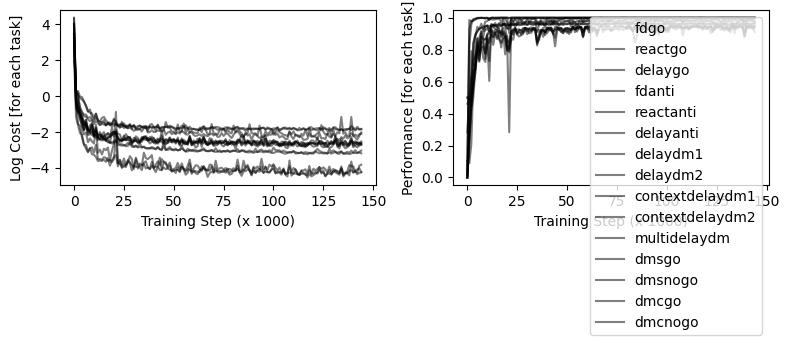

In [5]:
fig = plt.figure(figsize=(10, 5))
fname = os.path.join(m, 'log.json')

with open(fname, 'r') as f:
    log_all = json.load(f)

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))

# Define a colormap
cmap = plt.cm.get_cmap('Greys')

# Plot cost and performance for each rule
for i, rule in enumerate(hparams['rule_trains']):
    color = cmap(i+1 / (len(hparams['rule_trains']) + 2))  # Normalize color index

    ax1.plot(np.log(log_all['cost_'+rule]), '-', color=color, alpha=0.5, label=rule)
    ax2.plot(log_all['perf_'+rule], '-', color=color, alpha=0.5, label=rule)

# Set axis labels and title
ax1.set_xlabel('Training Step (x 1000)')
ax1.set_ylabel('Log Cost [for each task]')
ax2.set_xlabel('Training Step (x 1000)')
ax2.set_ylabel('Performance [for each task]')
# fig.suptitle(file)  # Set a common title for both subplots


# Add legend
ax2.legend()

# Show the plot
plt.tight_layout()
plt.show()


In [6]:
def remove_ax_lines(ax):
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
def label_categories(ax,rule):
    
    if 'dmc' in rule:
        plt.text(0.0, 0.05, 'Category 1', color='w', transform=ax.transAxes,fontsize = 12)
        plt.text(0.5, 0.05, 'Category 2', color='w', transform=ax.transAxes,fontsize = 12)
        
def Xcorr_trials(m,trial,x,epoch):
    
    t1 = trial.epochs[epoch][1]-5
    plt.imshow((np.corrcoef(x[:,trial_set,t1].T)))
    plt.title('time = '+str(t1))
    plt.ylabel('trial number')
    plt.xlabel('trial number')
#     label_categories(ax,rule)
    remove_ax_lines(ax)
    ax.set_yticks([])
    ax.set_xticks([])
    
def Xcorr_time(m,trial,x,trial_num = 0):
    
    plt.imshow((np.corrcoef(x[:,trial_num,:].T)))
    offset = 5
    al = .5

    for e in trial.epochs.keys():
        plt.plot([trial.epochs[e][0],trial.epochs[e][0]],[0,np.shape(x)[2]-1],'-w')
        plt.plot([0,np.shape(x)[2]-1],[trial.epochs[e][0],trial.epochs[e][0]],'-w')
        
        if e is not 'fix1':
            plt.text(trial.epochs[e][0]-2,-5,e[:-1]+ ' onset',rotation = 90,ha = 'left', va='bottom')

    plt.title('trial = '+str(trial_num),x = -.15,y = 1.05)
    plt.ylabel('time in trial')
    plt.xlabel('time in trial')
    remove_ax_lines(ax)

<>:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
<>:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
/var/folders/_8/556chyfx1hvd7cyh7d14w3dh0000gn/T/ipykernel_73991/3951221597.py:35: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if e is not 'fix1':


In [7]:
def plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 3, cat = False, labels=False,
                      mod_task1 = 'either',mod_task2 = 'either',first_stim = True):
    
    color_set = ['dimgray','gainsboro','dimgray','gainsboro']
    grad_cmap = plt.get_cmap('hsv')
    n_trials = np.shape(trial1.x)[1]+np.shape(trial2.x)[1]
    
    n_trials_show = 20
    trial_set = range(0,n_trials,int(n_trials/n_trials_show))
    
    if mod_task1 == 'either':
        if first_stim == True:
            stim_locs1 = np.min(trial1.stim_locs[:,[0,2]],axis=1)
        else:
            stim_locs1 = np.min(trial1.stim_locs[:,[1,3]],axis=1)
    elif mod_task1==1:
        if first_stim == True:
            stim_locs1 = trial1.stim_locs[:,0]
        else:
            stim_locs1 = trial1.stim_locs[:,1]
    elif mod_task1==2:
        if first_stim == True:
            stim_locs1 = trial1.stim_locs[:,2]
        else:
            stim_locs1 = trial1.stim_locs[:,3]
                     
    if mod_task2 == 'either':
        if first_stim == True:
            stim_locs2 = np.min(trial2.stim_locs[:,[0,2]],axis=1)
        else:
            stim_locs2 = np.min(trial2.stim_locs[:,[1,3]],axis=1)
    elif mod_task1==1:
        if first_stim == True:
            stim_locs2 = trial2.stim_locs[:,0]
        else:
            stim_locs2 = trial2.stim_locs[:,1]
    elif mod_task1==2:
        if first_stim == True:
            stim_locs2 = trial2.stim_locs[:,2]
        else:
            stim_locs2 = trial2.stim_locs[:,3]
    
    stim_locs = np.concatenate((stim_locs1,stim_locs2))
    task_binary = np.concatenate((np.ones(np.shape(trial1.x)[1]),np.zeros(np.shape(trial2.x)[1])))
    response_binary = [((task_binary[x]==0) & (stim_locs[x]>np.pi)) or ((task_binary[x]==1) & (stim_locs[x]<np.pi))
                       for x in range(len(stim_locs))]
    
    for ti in range(len(trial_set)):
        
        trial_num = trial_set[ti]
        stim_color = grad_cmap(stim_locs[trial_num]/(2*np.pi))
        task_color = color_set[ti<int(len(trial_set)/2)]
        response_color = color_set[2+response_binary[trial_num]]
        
        if 'y' in which_axes:
            
            if cat==True:
                ax.plot(ti,-ms*.25,'s',color = response_color,markersize = ms)
            else:
                ax.plot(ti,-ms*.25,'s',color = stim_color,markersize = ms)
            ax.plot(ti,-ms*.5,'s',color = stim_color,markersize = ms)
            ax.plot(ti,-ms*.75,'s',color = task_color,markersize = ms)
            
        if 'x' in which_axes:
            
            if cat==True:
                ax.plot(-ms*.25,ti,'s',color = response_color,markersize = ms)
            else:
                ax.plot(-ms*.25,ti,'s',color = stim_color,markersize = ms)
            ax.plot(-ms*.5,ti,'s',color = stim_color,markersize = ms)
            ax.plot(-ms*.75,ti,'s',color = task_color,markersize = ms)
            
    if labels == True:

        if cat==True:
            plt.text(len(trial_set),-ms*.15,'respond to <$\pi$')
        else:
            plt.text(len(trial_set),-ms*.15,'response angle')
        plt.text(len(trial_set),-ms*.4,'stimulus angle')
        plt.text(len(trial_set),-ms*.65,'task')

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from 

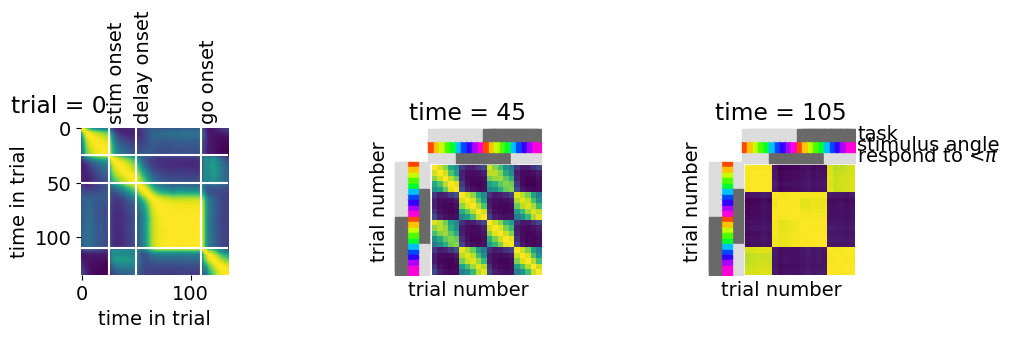

In [8]:
plt.rcParams.update({'font.size': 14})
n_trials_show = 20

cat_set = [13,14]
ri_set = cat_set
rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

_,x1 = gen_X_from_model_dir(m,trial1)
_,x2 = gen_X_from_model_dir(m,trial2)
x12 = np.concatenate((x1,x2),axis = 1)

fig = plt.figure(figsize=(12,4),tight_layout=True,facecolor='white')
ax = fig.add_subplot(1,4,1)
trial_set = range(0,np.shape(x1)[1],int(np.shape(x1)[1]/n_trials_show))
Xcorr_time(m,trial1,x1,trial_num = 0)

ax = fig.add_subplot(1,4,2)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'stim1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = True)

ax = fig.add_subplot(1,4,3)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'delay1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = True, labels=True)

fig_spec_fldr = os.path.join(figpath,'X_corr_trials')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])     
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))

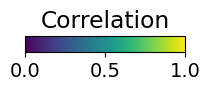

In [9]:
# plt.imshow([[1,0],[0,1]])
# plt.colorbar()

a = np.array([[0,1]])
plt.figure(figsize=(2, .8))
img = plt.imshow(a)
plt.gca().set_visible(False)
cax = plt.axes([0.1, 0.5, 0.8, 0.2])
plt.colorbar(orientation="horizontal", cax=cax)
plt.title('Correlation')
fig.tight_layout()
plt.savefig(os.path.join(figpath,"colorbar.pdf"))

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from 

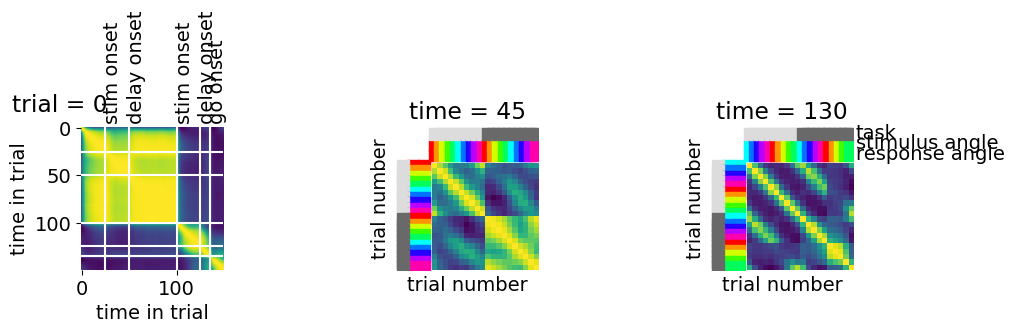

In [10]:
n_trials_show = 20

contin_set = [6,7]
ri_set = contin_set
rule1 = rules_dict['all'][ri_set[0]]
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)
trial2 = same_stim_trial(trial1, ri_set[1]) 
trial1 = gen_trials_from_model_dir(m,rule1,mode='test',noise_on = False)

_,x1 = gen_X_from_model_dir(m,trial1)
_,x2 = gen_X_from_model_dir(m,trial2)
x12 = np.concatenate((x1,x2),axis = 1)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))

fig = plt.figure(figsize=(12,4),tight_layout=True,facecolor='white')
ax = fig.add_subplot(1,4,1)
trial_set = range(0,np.shape(x1)[1],int(np.shape(x1)[1]/n_trials_show))
Xcorr_time(m,trial1,x1,trial_num = 0)

ax = fig.add_subplot(1,4,2)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'stim1')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = False,
                      mod_task1 = 1,mod_task2 = 2,first_stim = True)

ax = fig.add_subplot(1,4,3)
trial_set = range(0,np.shape(x12)[1],int(np.shape(x12)[1]/n_trials_show))
Xcorr_trials(m,trial1,x12,'delay2')
plot_task_labels(ax, m, trial1, trial2, which_axes = 'xy', ms = 8, cat = False, labels=True,
                      mod_task1 = 1,mod_task2 = 2,first_stim = False)

fig_spec_fldr = os.path.join(figpath,'X_corr_trials')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = '_'.join([rules_dict['all'][ri_set[0]],rules_dict['all'][ri_set[1]]])     
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.png'))

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from 

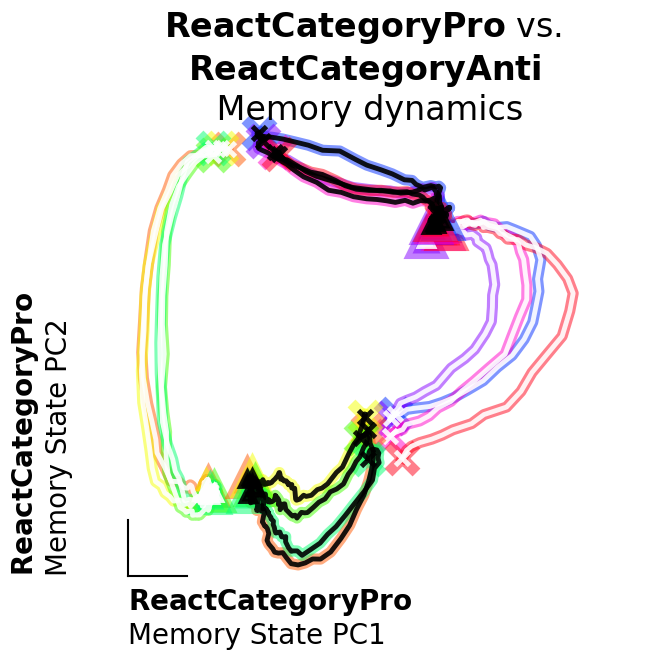

In [11]:
########## X TASK ###########

from tools_lnd import make_D_use, interp2d

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = cat_set
epoch_set = ['delay1','delay1']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = False

cmap_grad = plt.get_cmap('plasma')
script_name = 'interp_tasks_small_init_mov'

rule_axs = 0
epoch = epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = ['w','k'],
         interp = interp,q_thresh = .0000001,rule_axs = rule_axs, plot_unstable = False, n_skip_interps=1,
        figpath = figpath,fig_size = 7, color_stim = False,stability_thresh = 1.05,fp_first = False)

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters

/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from 

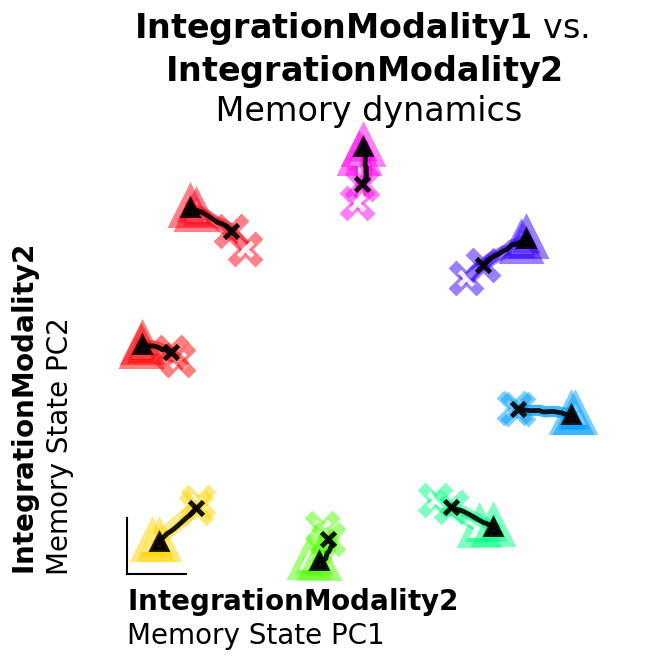

In [12]:
########## X TASK ###########

from tools_lnd import interp2d, make_D_use

offset = 0
t_set = [offset, offset]
trial_num = [int(offset/4), int(offset/4)]

rule_set = [6,7]
epoch_set = ['delay2','delay2']
linestyle = ['-','-']
axs = 'pca_h'
tol_q = 1e-6
interp = False

cmap_grad = plt.get_cmap('plasma')
script_name = 'interp_tasks_small_init_mov'

rule_axs = 1
epoch = 'delay2'#epoch_set[rule_axs]
rule = rules_dict['all'][rule_set[rule_axs]]
ti = trial_num[rule_axs]
D_use = make_D_use(m,rule,epoch,ti,axs)

epoch_name_ax, rule_name_ax, _, _ = take_names(epoch,rules_dict['all'][rule_set[rule_axs]])
ax_labels_master = [r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC1',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC2',
                    r"$\bf{"+rule_name_ax+"}$"+'\n '+epoch_name_ax+' State PC3']

interp2d(m,D_use,rule_set,epoch_set,t_set,script_name = script_name,tol_q = tol_q,cmap_discrete = ['w','k'],
         interp = interp,q_thresh = .0001,rule_axs = rule_axs, plot_unstable = True, n_skip_interps=1,
        figpath = figpath,fig_size = 7, color_stim = False, stability_thresh = 2)

In [13]:
p_ins = {}
p_ins['No Perturb'] = {}
p_ins['No Perturb']['ri_set'] = [6,7]
p_ins['No Perturb']['init'] = 0
p_ins['No Perturb']['id'] = 0

p_ins['Init from Shared Motif'] = {}
p_ins['Init from Shared Motif']['ri_set'] = [6,7]
p_ins['Init from Shared Motif']['init'] = 1
p_ins['Init from Shared Motif']['id'] = 1

p_ins['Init from Other Motif'] = {}
p_ins['Init from Other Motif']['ri_set'] = [6,14]
p_ins['Init from Other Motif']['init'] = 1
p_ins['Init from Other Motif']['id'] = 2

Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt


/Users/lauradriscoll/miniconda3/envs/flex_mult/lib/python3.10/site-packages/tensorflow/python/keras/engine/base_layer_v1.py:1702: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use `layer.add_weight` method instead.
  warnings.warn('`layer.add_variable` is deprecated and '


Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters from /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Model restored from file: /Users/lauradriscoll/Documents/data/flexible_multitask/suppfig7/softplus/0/model.ckpt
Variables being optimized:
<tf.Variable 'rnn/leaky_rnn_cell/kernel:0' shape=(148, 128) dtype=float32_ref>
<tf.Variable 'rnn/leaky_rnn_cell/bias:0' shape=(128,) dtype=float32_ref>
<tf.Variable 'output/weights:0' shape=(128, 3) dtype=float32_ref>
<tf.Variable 'output/biases:0' shape=(3,) dtype=float32_ref>
INFO:tensorflow:Restoring parameters

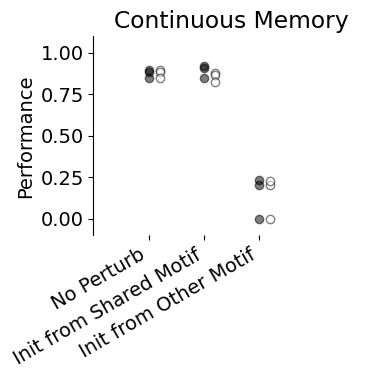

In [14]:
plt.rcParams.update({'font.size': 14})

fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

for rnn_type in ['LeakyRNN']:
        for w_init in ['diag','randgauss']:#
            for seed in ['0','1','2']:

                m = os.path.join(p_data,fig_name,activation,seed)
        
                for key in p_ins.keys():
                    perf = init_from_other_task(m,p_ins[key]['ri_set'],p_ins[key]['init'])

                    plt.plot(p_ins[key]['id']+x_off,np.mean(perf),'ok',markerfacecolor = c,alpha = .5)

plt.ylabel('Performance')
tit = 'Continuous Memory'
plt.title(tit)
plt.xticks(range(len(p_ins.keys())),['No Perturb','Init from Shared Motif','Init from Other Motif'],
           rotation = 30,ha = 'right')
plt.ylim([-.1,1.1])
plt.xlim([-1,len(p_ins.keys())+1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig_spec_fldr = os.path.join(figpath,'Init_X_motifs')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = tit   
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))

In [ ]:
p_ins = {}
p_ins['No Perturb'] = {}
p_ins['No Perturb']['ri_set'] = [13,14]
p_ins['No Perturb']['init'] = 0
p_ins['No Perturb']['id'] = 0

p_ins['Init from Shared Motif'] = {}
p_ins['Init from Shared Motif']['ri_set'] = [13,14]
p_ins['Init from Shared Motif']['init'] = 1
p_ins['Init from Shared Motif']['id'] = 1

p_ins['Init from Other Motif'] = {}
p_ins['Init from Other Motif']['ri_set'] = [13,6]
p_ins['Init from Other Motif']['init'] = 1
p_ins['Init from Other Motif']['id'] = 2

In [ ]:
fig = plt.figure(figsize=(4,4),tight_layout=True,facecolor='white')
ax = plt.subplot(111)

for rnn_type in ['LeakyRNN']:
        for w_init in ['diag']:#,'randgauss'
            for seed in ['0','1','2']:

                m = os.path.join(p_data,fig_name,activation,seed)
        
                for key in p_ins.keys():
                    perf = init_from_other_task(m,p_ins[key]['ri_set'],p_ins[key]['init'])

                    plt.plot(p_ins[key]['id']+x_off,np.mean(perf),'ok',markerfacecolor = c,alpha = .5)


plt.ylabel('Performance')
tit = 'Category Memory'
plt.title(tit)
plt.xticks(range(len(p_ins.keys())),['No Perturb','Init from Shared Motif','Init from Other Motif'],
           rotation = 30,ha = 'right')
plt.ylim([-.1,1.1])
plt.xlim([-1,len(p_ins.keys())+1])
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

fig_spec_fldr = os.path.join(figpath,'Init_X_motifs')
if not os.path.exists(os.path.join(figpath,fig_spec_fldr)):
    os.makedirs(os.path.join(figpath,fig_spec_fldr))
    
tasks_fldr = tit   
plt.savefig(os.path.join(figpath,fig_spec_fldr,tasks_fldr+'.pdf'))